In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%pylab
from Xana import Xana
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import h5py
import pandas as pd

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
rawdir ='/asap3/petra3/gpfs/p10/2022/data/11014696/raw/'

In [3]:
!ls ../03-masks/

G2p1_NP_2_180_00005_00.npy     HydLys_0p25_2_00015_00_g.npy
HydLys_0p25_2_00001_00_g.npy   HydLys_0p25_2_00015_00.npy
HydLys_0p25_2_00001_00.npy     HydLys_0p29_2_00001_00.npy
HydLys_0p25_2_00002_00_g.npy   HydLys_0p29_2_00002_00.npy
HydLys_0p25_2_00002_00.npy     HydLys_0p29_2_00003_00.npy
HydLys_0p25_2_00003_00_g.npy   HydLys_0p29_2_00004_00.npy
HydLys_0p25_2_00003_00.npy     HydLys_0p29_2_00005_00.npy
HydLys_0p25_2_00004_00_g.npy   HydLys_0p29_2_00006_00.npy
HydLys_0p25_2_00004_00.npy     HydLys_0p29_2_00007_00.npy
HydLys_0p25_2_00005_00_02.npy  HydLys_0p29_2_00008_00.npy
HydLys_0p25_2_00005_00_03.npy  HydLys_0p29_2_00009_00.npy
HydLys_0p25_2_00005_00_g.npy   HydLys_0p29_2_00010_00.npy
HydLys_0p25_2_00005_00.npy     HydLys_0p29_2_00011_00.npy
HydLys_0p25_2_00005_g.npy      HydLys_0p29_2_00012_00.npy
HydLys_0p25_2_00006_00_g.npy   HydLys_0p29_2_00013_00.npy
HydLys_0p25_2_00006_00.npy     HydLys_0p29_2_00014_00.npy
HydLys_0p25_2_00006_g.npy      HydLys_0p29_2_00015_00.npy
HydLys_0p25_

In [4]:
!ls ../04-setups

analysis_database.pkl
eiger4m-03-powders-01.pkl
eiger4m-03-powders-02-test.pkl
eiger4m-03-powders-03.pkl
eiger4m-03-powders-phis-02.pkl
eiger4m-03-powders-phis-03.pkl
eiger4m-03-powders-phis.pkl
setup-G2p1_NP_2_180_00002_dbid00.pkl
setup-G2p1_NP_2_180_00005_dbid00.pkl
setup-HydLys_0p25_2_00001_dbid00.pkl
setup-HydLys_0p25_2_00002_dbid00.pkl
setup-HydLys_0p25_2_00003_dbid00-phis03.pkl
setup-HydLys_0p25_2_00003_dbid00-phis.pkl
setup-HydLys_0p25_2_00003_dbid00.pkl
setup-HydLys_0p25_2_00004_dbid00-phis.pkl
setup-HydLys_0p25_2_00004_dbid00.pkl
setup-HydLys_0p25_2_00005_dbid00-phis.pkl
setup-HydLys_0p25_2_00005_dbid00.pkl
setup-HydLys_0p25_2_00006_dbid00-phis.pkl
setup-HydLys_0p25_2_00006_dbid00.pkl
setup-HydLys_0p25_2_00007_dbid00-phis03.pkl
setup-HydLys_0p25_2_00007_dbid00-phis.pkl
setup-HydLys_0p25_2_00007_dbid00.pkl
setup-HydLys_0p25_2_00008_dbid00-phis.pkl
setup-HydLys_0p25_2_00008_dbid00.pkl
setup-HydLys_0p25_2_00009_dbid00-phis.pkl
setup-HydLys_0p25_2_00009_dbid00.pkl
setup-HydLys_0p2

# Funtions

In [9]:
def mask_streaks(nbins=10, thres=2., qvalue=0.03, phiwidth=2., show=True, save=False):
    """Calculate a new mask that masks streaks.
    
    Args:
        nbins (int): the number of time bins. Instead of averaging all images, the function is 
            looping ofer nbin time bins.
        thres: (float): the threshold to identify streaks.
        phiwidth (float): the angular width of a masked streak.
        show (bool): if a plot should be created showing the results.
        
    Returns:
        newmask (np.ndarray): the new mask.
        
    """
    ana = d
    
    newmask = ana.setup.mask.copy()
    
    nframes = ana.meta.loc[database_id, 'nframes']
    stepsize = nframes // nbins
    
    phimap = ana.setup.ai.chiArray()*180/np.pi
    
    for first in range(0,nframes-stepsize,stepsize):
        avr = d.get_series(database_id, first=first, last=first+stepsize, verbose=False)
        avr = avr.mean(0)
        I, q, p = ana.setup.ai.integrate2d(avr, 200, mask=~newmask, method="cython", )
        qbin = np.argmin(np.abs(q-qvalue))

        phiinds = I[:,qbin] > thres
        for phi in p[phiinds]:
            ind = (phimap < (phi+phiwidth/2)) & (phimap > (phi-phiwidth/2))
            newmask[ind] = 0
            
        if show:
            I, q, p = ana.setup.ai.integrate2d(avr, 200, mask=~newmask, method="cython", dummy=np.nan)
            if first == 0:  
                fig, axs = plt.subplots(3, 1, figsize=(8,8), constrained_layout=True)
                
                a = axs.flat[1]
                my_cmap = plt.get_cmap('inferno')
                pc = a.imshow(I.T, norm=LogNorm(), extent=[p[-1], p[0], q[0], q[-1]], origin='lower', aspect="auto")
                a.set_xlabel('phi')
                a.set_ylabel('q (nm-1)')
                
                a = axs.flat[0]
                avr[newmask==0] = np.nan
                im = a.imshow(avr, norm=LogNorm())
                
                a = axs.flat[2]
                ln, = a.plot(I[:,qbin], 'o', ms=2)
                a.hlines(thres, 0, 360, ls='--', color='k')
                a.set_xlabel('phi')
                a.set_ylabel(f'intensity at q={q[qbin]:.2}nm-1')
                fig.canvas.draw()
                time.sleep(5)
            else:
                pc.set_data(I.T)
                
                avr[newmask==0] = np.nan
                im.set_data(avr) 
                
                ln.set_ydata(I[:,qbin])
                axs.flat[2].autoscale()

            fig.canvas.draw()
            
    #if not os.path.isdir('./masks/'):
    #    os.mkdir('masks')
    if save:
        filename = f'../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy'
        np.save(filename, newmask)
        print(f"New mask saved as: {filename}")

    return newmask

def visit_func(name, node):
    '''
    Return all groups and datasets name and shapes of h5 file called name
    '''
    if isinstance(node, h5py.Group):
        print(node.name)
    elif isinstance(node, h5py.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'is an object Dataset')
        else:
            print('\t', node.name, node.shape)
    else:
        print(node.name, 'is an unknown type')

# Elog

In [6]:
elog = pd.read_pickle("../02-sources/elog")

In [7]:
# elog[elog['folder'].str.contains('G2p1_NP_2_180', na=False)]
elog[(elog['folder'].str.contains('HydLys_0p25', na=False))
    & (elog['# Si absorber (25um each)'] == 6)
#      & (elog['Target temperature (K)'] == 'RT')
    ]

,Run n,Sample,Sample no. (label),folder,scan number,Short comment,cooling rate (K/min),Target temperature (K),Detector,Beam size (um),# Si absorber (25um each),transmission,Exposure time per frame (s),number of frames,Total exposure time (s),Mesh (spots x lines),comments
557,448,hyd lys h0.25,1.1,HydLys_0p25_2_00003,NaN,fluences,NaN,290,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
559,450,hyd lys h0.25,1.1,HydLys_0p25_2_00005,NaN,temperatures epseries,NaN,280,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
560,451,hyd lys h0.25,1.1,HydLys_0p25_2_00006,NaN,temperatures epseries,NaN,270,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
561,452,hyd lys h0.25,1.1,HydLys_0p25_2_00007,NaN,temperatures epseries,NaN,260,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
562,453,hyd lys h0.25,1.1,HydLys_0p25_2_00008,NaN,temperatures epseries,NaN,250,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
563,454,hyd lys h0.25,1.1,HydLys_0p25_2_00009,NaN,temperatures epseries,NaN,240,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
564,455,hyd lys h0.25,1.1,HydLys_0p25_2_00010,NaN,temperatures epseries,NaN,230,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
565,456,hyd lys h0.25,1.1,HydLys_0p25_2_00011,NaN,temperatures epseries,NaN,220,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
566,457,hyd lys h0.25,1.1,HydLys_0p25_2_00012,NaN,temperatures epseries,NaN,210,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
567,458,hyd lys h0.25,1.1,HydLys_0p25_2_00013,NaN,temperatures epseries,NaN,200,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN


# Initialize Xana and Load Data

In [8]:
!ls ../04-setups

analysis_database.pkl
eiger4m-03-powders-01.pkl
eiger4m-03-powders-02-test.pkl
eiger4m-03-powders-03.pkl
eiger4m-03-powders-phis-02.pkl
eiger4m-03-powders-phis-03.pkl
eiger4m-03-powders-phis.pkl
setup-G2p1_NP_2_180_00002_dbid00.pkl
setup-G2p1_NP_2_180_00005_dbid00.pkl
setup-HydLys_0p25_2_00001_dbid00.pkl
setup-HydLys_0p25_2_00002_dbid00.pkl
setup-HydLys_0p25_2_00003_dbid00-phis03.pkl
setup-HydLys_0p25_2_00003_dbid00-phis.pkl
setup-HydLys_0p25_2_00003_dbid00.pkl
setup-HydLys_0p25_2_00004_dbid00-phis.pkl
setup-HydLys_0p25_2_00004_dbid00.pkl
setup-HydLys_0p25_2_00005_dbid00-phis.pkl
setup-HydLys_0p25_2_00005_dbid00.pkl
setup-HydLys_0p25_2_00006_dbid00-phis.pkl
setup-HydLys_0p25_2_00006_dbid00.pkl
setup-HydLys_0p25_2_00007_dbid00-phis03.pkl
setup-HydLys_0p25_2_00007_dbid00-phis.pkl
setup-HydLys_0p25_2_00007_dbid00.pkl
setup-HydLys_0p25_2_00008_dbid00-phis.pkl
setup-HydLys_0p25_2_00008_dbid00.pkl
setup-HydLys_0p25_2_00009_dbid00-phis.pkl
setup-HydLys_0p25_2_00009_dbid00.pkl
setup-HydLys_0p2

In [10]:
sample = 'HydLys_0p25_2' # runs 168 on HydLys_0p29_2 or HydLys_0p25_2
run_series = 8
maskfile = '../03-masks/mask-eiger4m-05-grande.npy'
# maskfile = '/asap3/petra3/gpfs/p10/2022/data/11014696/scratch_cc/masks/mask-eiger4m-04.npy'
setup = '../04-setups/eiger4m-03-powders-phis-03.pkl'

In [11]:
d = Xana(fmtstr='p10_eiger_h5', # format string that defines how the date are read
           sample=sample,  # optional: sample name used in data base
           detector='eiger4m', # file that conatains the blemish / mask 
           maskfile=maskfile, # (optional: but necessary for analysis)
           setupfile=setup)

Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/eiger4m-03-powders-phis-03.pkl.


In [12]:
d.connect(f'{rawdir}{sample}_{run_series:05d}')
d.meta

,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir
0,8,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...


## Read 2d images and plot

After the connection to a dataset has been established, the data can be accessed. In the most simple case, a 3D-array is returned (time x Pixel-X x Pixel-Y).

In [13]:
idx = 0
database_id = d.meta[d.meta['series']==run_series].index.values[idx]
filename = d.meta.loc[database_id, 'master']

In [14]:
#data = d.get_series(database_id, method='full', verbose=True)#, last=1000)
avr, V = d.get_series(database_id, method='average', verbose=True, last=1000)
print(f"Loaded data with shape {np.shape(avr)}")

H5 file using external links.
First images is:  0
Last image is:  1000
Loading data in chunks of 200 images.
[============================================================] 100.0%...
Loaded data with shape (2167, 2070)


For setting the ROIs properly, it would be convenient to have a time averaged image. The command is the same except the method kwarg has been changed to _average_. Now the command will return a list containing the average intensities, avr , and the variance over time, V.

<IPython.core.display.Javascript object>


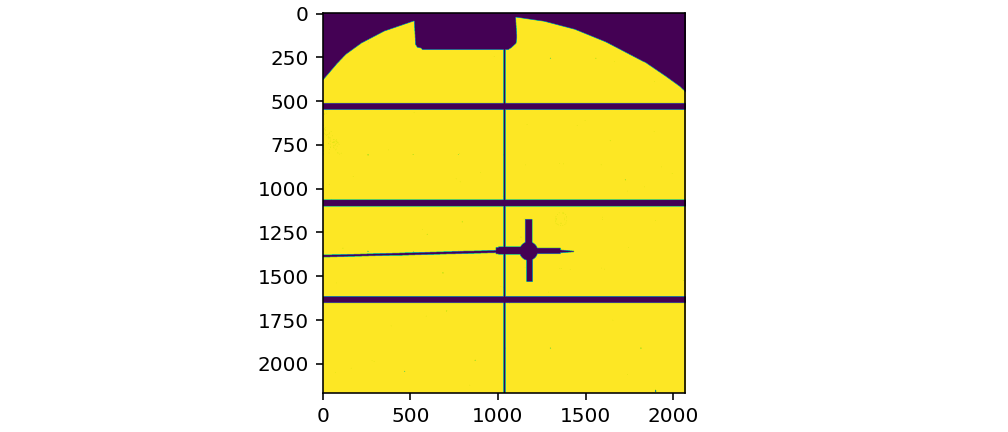

In [15]:
figure(figsize=(7,3), constrained_layout=True)
imshow(d.setup.mask)#, norm=LogNorm())

<IPython.core.display.Javascript object>


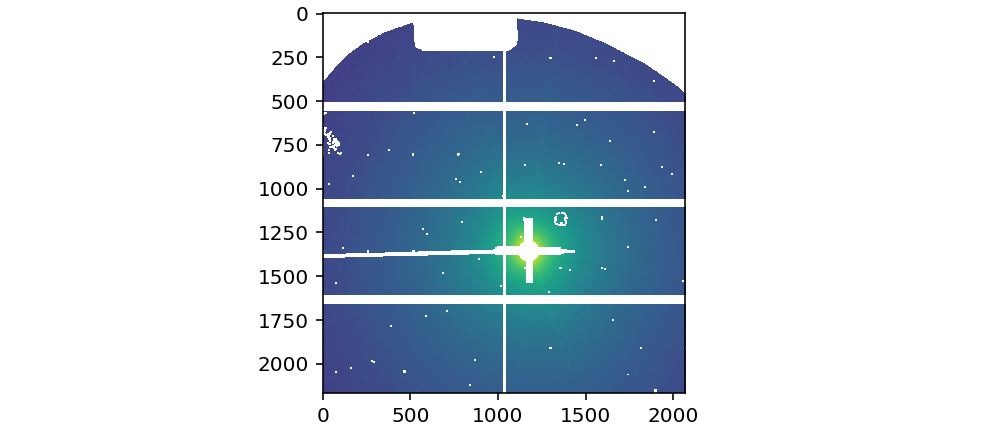

In [16]:
#avr = data.mean(0)
#d.setup.mask = np.load('../03-masks/mask-eiger4m-05-grande.npy')
avr[d.setup.mask==0] = np.nan

figure(figsize=(7,3), constrained_layout=True)
imshow(avr, norm=LogNorm())

## Mask Streaks

`ana.setup.ai.integrate2d` can be used to calculate the azimhuthal integration. Remember that this step requires that you called `ana.setup.make` before (we did this a couple of cells before). Look at the intensity fluctuations in the second plot and define a `threshold`. Values above `threshold` will be masked as streaks. You can also define a `qvalue` that sets the q-section (white dashed line) that should be used for identifying a streak.

### Run the following two cells to manually import the mask, otherwise skip

In [17]:
m1 = np.load(f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy")
m2 = np.load('../03-masks/mask-eiger4m-05-grande.npy')
mm = m1*m2
d.setup.mask = mm #np.load(f"../masks/{sample}_{run_series:05d}_{database_id:02d}.npy")

<IPython.core.display.Javascript object>


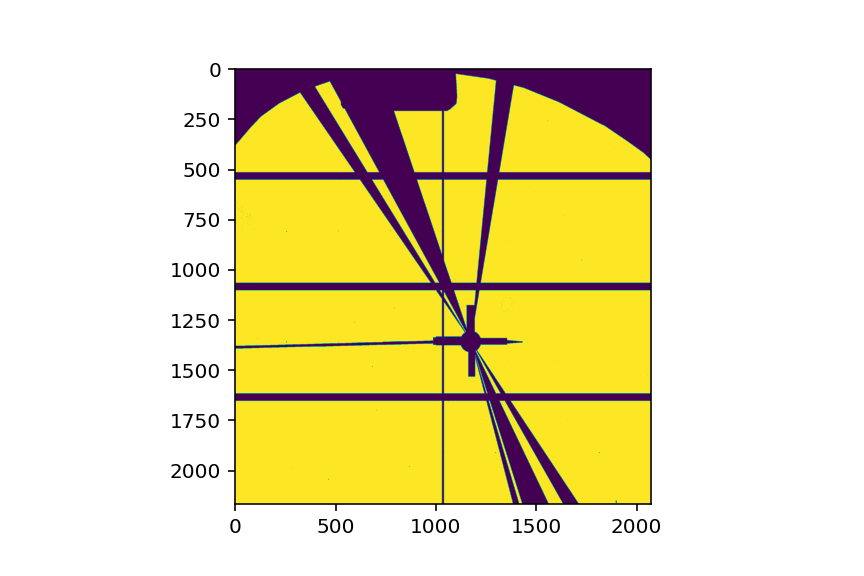

In [18]:
plt.figure()
plt.imshow(d.setup.mask);

### If mask is imported manually, skip this part

<IPython.core.display.Javascript object>


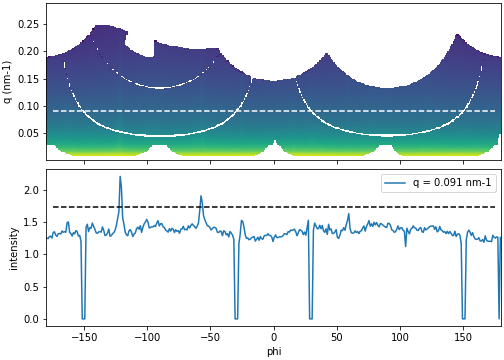

In [505]:
qvalue = 0.09

I, q, p = d.setup.ai.integrate2d(avr, 200, mask=~d.setup.mask, method="cython", )
qbin = np.argmin(np.abs(q-qvalue))

fig, (ax1, ax2) = subplots(2, 1, figsize=(7,5), constrained_layout=True, sharex=True)
pc = ax1.pcolor(p, q, I.T, norm=LogNorm())#, shading='auto')
ax1.set_ylabel('q (nm-1)')
ax1.hlines(q[qbin], -175, 175, ls='--', color='w')

threshold = np.quantile(I[:,qbin], .99)

ax2.plot(p, I[:,qbin], label=f"q = {q[qbin]:.3f} nm-1")
ax2.set_ylabel('intensity')
ax2.set_xlabel('phi')

ax2.hlines(threshold, -175, 175, ls='--', color='k')
ax2.legend()

<IPython.core.display.Javascript object>


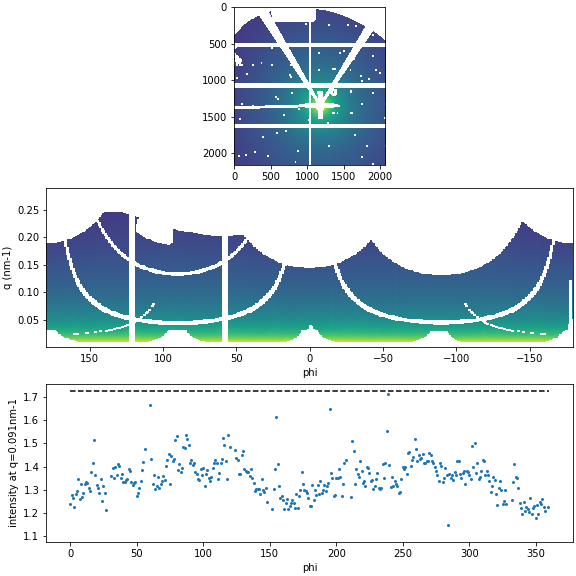

New mask saved as: ../03-masks/HydLys_0p29_2_00015_00.npy


In [506]:
newmask = mask_streaks(thres=threshold, qvalue=qvalue, save=True)

In [507]:
d.setup.mask = newmask # we update the mask

**Create a setup with many q-bins but only horizontal and vertical axis**

In [508]:
d.setup.phiv

array([[-22.5,  45. ],
       [ 67.5,  45. ]])

In [509]:
d.setup.qv

array([0.05, 0.05, 0.1 , 0.1 , 0.15, 0.15])

In [510]:
# d.setup.mask = newmask # we update the mask

# # for geometry 1 it would be
# qv_init =  [(np.arange(0.012, 0.2, 0.01), 9.5e-3)]
# # phi_init = [(np.arange(0, 360, 360), 360)]

# # d.defineqrois(avr, qv_init=qv_init, plot=2, d=8000, phiv_init=phi_init)#, mirror=True) plot='ROIS'

# # define new setup
# # qv_init =  [(np.arange(1.2e-2, 2.3e-1, 1e-2), 9.5e-3)]
# # phi_init = [(np.arange(0, 20, 35), 35)]

# d.defineqrois(avr, qv_init=qv_init, plot=2, d=2000, )#phiv_init=phi_init)#, mirror=True) plot='ROIS'

### Run again from here if the mask was imported manually

<IPython.core.display.Javascript object>


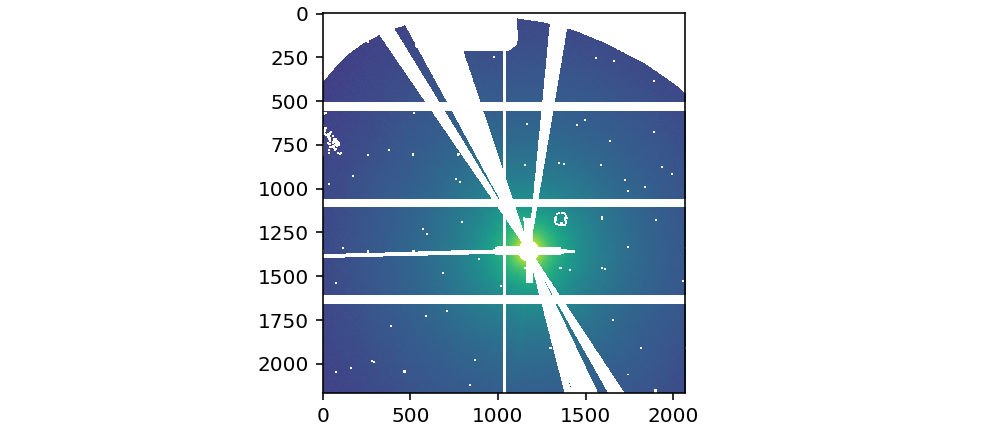

In [19]:
#avr = data.mean(0)
avr[d.setup.mask==0] = np.nan

figure(figsize=(7,3), constrained_layout=True)
imshow(avr, norm=LogNorm())
#plt.savefig(f'../04-plots/{sample}_{run_series:05d}-{database_id}-mask.png', dpi=200);

In [20]:
d.mksavdir('../04-setups/') # folder to save the results
d.savesetup(f'setup-{sample}_{run_series:05d}_dbid{database_id:02d}-phis03')

Changing savdir to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/analysis_database.pkl
Successfully loaded database

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/setup-HydLys_0p25_2_00008_dbid00-phis03.pkl


# Analyse

In [21]:
ls /asap3/petra3/gpfs/p10/2021/data/11009212/processed/post-analysis/

01-notebooks/  05-source/       masks/         xpcs-results-live/
02-scripts/    06-paper-plots/  setups/        xpcs-results-mario-testing/
03-examples/   07-paper-stuff/  ttcs.png       xpcs-results-T-dep/
04-plots/      geom/            xpcs-results/


In [22]:
sample, run_series

('HydLys_0p25_2', 8)

In [23]:
# sample = 'HydLys_0p25_2'
# run_series = 5
print(f"{sample}_{run_series:05}")
detector = 'eiger4m'

HydLys_0p25_2_00008


In [24]:
!ls ../03-masks/

G2p1_NP_2_180_00005_00.npy     HydLys_0p25_2_00015_00_g.npy
HydLys_0p25_2_00001_00_g.npy   HydLys_0p25_2_00015_00.npy
HydLys_0p25_2_00001_00.npy     HydLys_0p29_2_00001_00.npy
HydLys_0p25_2_00002_00_g.npy   HydLys_0p29_2_00002_00.npy
HydLys_0p25_2_00002_00.npy     HydLys_0p29_2_00003_00.npy
HydLys_0p25_2_00003_00_g.npy   HydLys_0p29_2_00004_00.npy
HydLys_0p25_2_00003_00.npy     HydLys_0p29_2_00005_00.npy
HydLys_0p25_2_00004_00_g.npy   HydLys_0p29_2_00006_00.npy
HydLys_0p25_2_00004_00.npy     HydLys_0p29_2_00007_00.npy
HydLys_0p25_2_00005_00_02.npy  HydLys_0p29_2_00008_00.npy
HydLys_0p25_2_00005_00_03.npy  HydLys_0p29_2_00009_00.npy
HydLys_0p25_2_00005_00_g.npy   HydLys_0p29_2_00010_00.npy
HydLys_0p25_2_00005_00.npy     HydLys_0p29_2_00011_00.npy
HydLys_0p25_2_00005_g.npy      HydLys_0p29_2_00012_00.npy
HydLys_0p25_2_00006_00_g.npy   HydLys_0p29_2_00013_00.npy
HydLys_0p25_2_00006_00.npy     HydLys_0p29_2_00014_00.npy
HydLys_0p25_2_00006_g.npy      HydLys_0p29_2_00015_00.npy
HydLys_0p25_

In [25]:
# m1 = np.load(f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy")
# m2 = np.load('../03-masks/mask-eiger4m-05-grande.npy')
# mm = np.save(f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}_g.npy", m1*m2)
#d.setup.mask = mm #np.load(f"../masks/{sample}_{run_series:05d}_{database_id:02d}.npy")

# # # m1 = np.load('../03-masks/HydLys_0p25_2_00001_00.npy')
# m1 = np.load(f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy")
# m2 = np.load('../03-masks/mask-eiger4m-04.npy')
# np.save(f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}_03.npy", m1*m2)

In [26]:
# maskfile = f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy"
maskfile = f"../03-masks/{sample}_{run_series:05d}_{database_id:02d}.npy"
setupfile = f"../04-setups/setup-{sample}_{run_series:05d}_dbid{database_id:02d}-phis03.pkl" # setup

d = Xana(fmtstr='p10_eiger_h5', 
           sample=sample,
           detector=detector, 
           maskfile=maskfile,
           setupfile=setupfile)

Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/setup-HydLys_0p25_2_00008_dbid00-phis03.pkl.


In [27]:
d.connect(f'{rawdir}{sample}_{run_series:05d}')
d.mksavdir('../05-analysis-phis/')  # ../05-analysis-02/

database_id = d.meta[d.meta['series']==run_series].index.values[idx]
display(d.meta.loc[[database_id]])

Changing savdir to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl
Successfully loaded database


,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir
0,8,0,0.503,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...


In [28]:
d.analyze(database_id, 'xpcs', verbose=True, nprocs=4, nread_procs=1, norm='symmetric',
          saxs='compute', first=10, #last=5000,
          twotime_par=list(np.arange(len(d.setup.qroi)))) #, use_multitau=False, chn=64)



#### Starting xpcs Analysis ####
Series: 0 in folder /asap3/petra3/gpfs/p10/2022/data/11014696/raw/HydLys_0p25_2_00008

Using 1 processes to read data.
Calculating average SAXS image.
Number of images is: 1990
shape of image section is: (1833, 1918)
Start computing SAXS for normalization.
Done
Shape of saxs_img: (1833, 1918)
Sum of saxs_img: 19813668.0
Number of ROIs:  20
Using 4 processes.
Number of registers is 8 with 72 total correlation points.
[============================================================] 100.0%...
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 8.18 min

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/s0008_0068.pkl

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl


In [29]:
d.analyze(database_id, 'saxs', verbose=True, first=10)



#### Starting saxs Analysis ####
Series: 0 in folder /asap3/petra3/gpfs/p10/2022/data/11014696/raw/HydLys_0p25_2_00008

Using 1 processes to read data.

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/s0008_0069.pkl

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl


## Explore matlab masks

In [170]:
ls /asap3/petra3/gpfs/p10/2022/data/11014696/shared/Masks

Mask_01_e4m_full.mat  Mask_02_e500_full.mat  Mask_04_e4m_part.mat
Mask_02_e4m_full.mat  Mask_03_e4m_part.mat   p300_mask_9_3_2022.edf


In [165]:
import scipy.io

In [181]:
# import numpy as np
# import h5py
# f = h5py.File('/asap3/petra3/gpfs/p10/2022/data/11014696/shared/Masks/Mask_04_e4m_part.mat','r')
# # data = f.get('data/variable1')
# # data = np.array(data) # For converting to a NumPy array

In [182]:
mat = scipy.io.loadmat('/asap3/petra3/gpfs/p10/2022/data/11014696/shared/Masks/Mask_04_e4m_part.mat')

In [183]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'MaskInfo'])

In [186]:
mat['MaskInfo']

array([[(array([[ 866, 1153],
               [ 865, 1586],
               [1454, 1589],
               [1452, 1152]], dtype=uint16), array([[5]], dtype=uint8), array([[array([[1169, 1377],
                       [1164, 1592],
                       [1177, 1593],
                       [1179, 1377]], dtype=uint16),
                array([[1198, 1361],
                       [1456, 1359],
                       [1456, 1350],
                       [1198, 1355]], dtype=uint16),
                array([[1179, 1331],
                       [1179, 1146],
                       [1170, 1147],
                       [1172, 1331]], dtype=uint16),
                array([], shape=(0, 0), dtype=uint8),
                array([[ 857, 1347],
                       [1139, 1346],
                       [1148, 1336],
                       [1160, 1328],
                       [1169, 1325],
                       [1180, 1325],
                       [1190, 1325],
                       [1200, 1329],
      